Dataset loaded successfully with corrected headers.
First 5 rows of the dataset:
| Respondent's current age   | Type of place of residence   | Highest educational level   | Source of drinking water   | Source of toilets    | Frequency of reading newspaper or magazine   | Frequency of watching television   | Type of cooking fuel   | Wealth index   | Marriage to first birth interval (months)   | Number of antenatal visits during pregnancy   | Birth weight in kilograms (3 decimals)   | Body Mass Index   | Hemoglobin level (g/dl - 1 decimal)   | Anemia level   | Gutkha/Paan masala with tobacco   | Respondent currently working   | Drinks alcohol   | Currently has thyroid disorder   | Frequency eats pulses or beans   | Frequency eats dark green leafy vegetable   | Frequency eats fruits   |
|:---------------------------|:-----------------------------|:----------------------------|:---------------------------|:---------------------|:---------------------------------------------|:--------------

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[06:52:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





=== Model Comparison ===
+---------------------+------------+-----------------+--------------+-----------+-----------------+--------------+----------+
| Model               |   Accuracy |   Precision (1) |   Recall (1) |    F1 (1) |   Precision (0) |   Recall (0) |   F1 (0) |
|---------------------+------------+-----------------+--------------+-----------+-----------------+--------------+----------|
| Tuned RF            |   0.806348 |        0.187446 |    0.0429485 | 0.0698846 |        0.831338 |     0.962032 | 0.891923 |
| Original RF         |   0.618381 |        0.204597 |    0.433879  | 0.278069  |        0.850346 |     0.656007 | 0.74064  |
| XGBoost             |   0.58319  |        0.196598 |    0.473232  | 0.277791  |        0.84934  |     0.605614 | 0.707063 |
| Logistic Regression |   0.524008 |        0.196042 |    0.5837    | 0.293506  |        0.857728 |     0.511834 | 0.641102 |
+---------------------+------------+-----------------+--------------+-----------+-----------

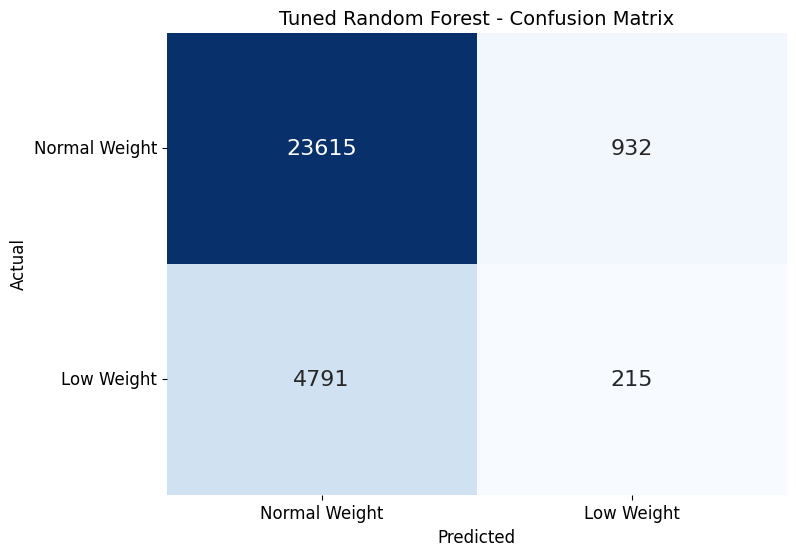

<ipython-input-7-059bba518b15>:234: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




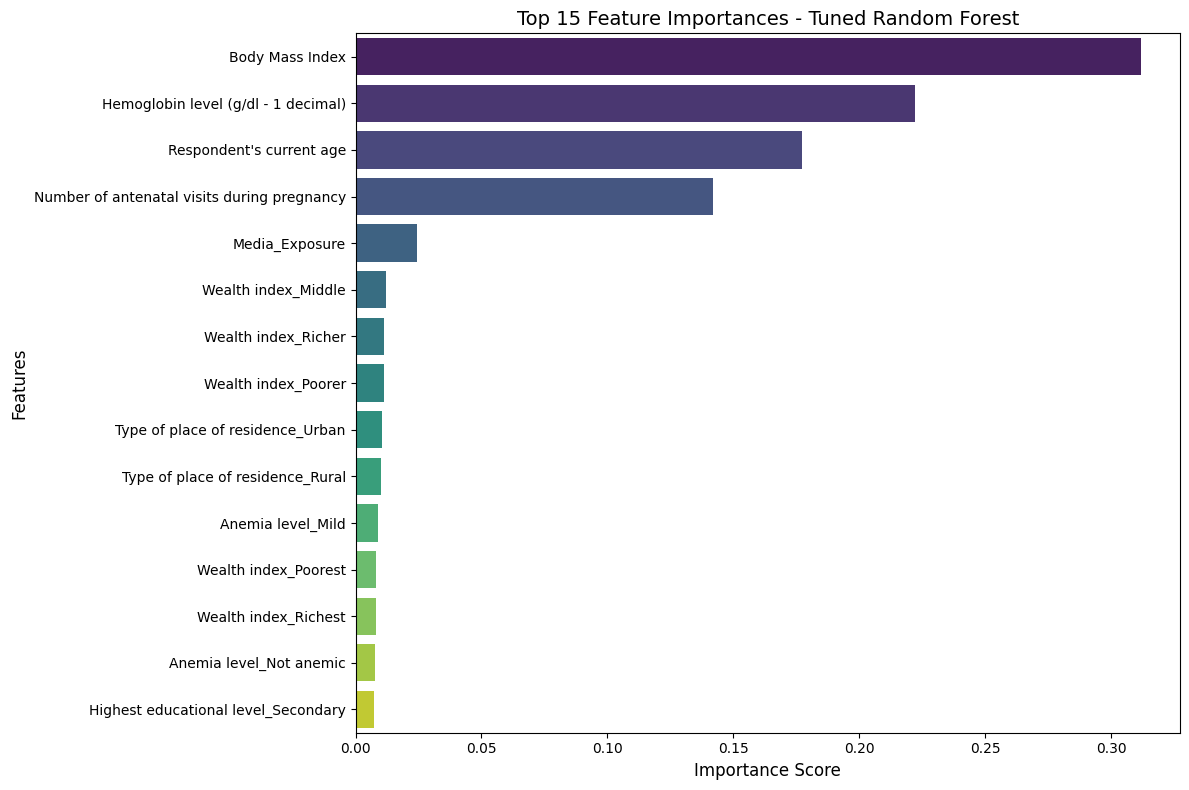

Preparation of a new explainer is initiated

  -> data              : 29553 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 29553 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Tuned Random Forest
  -> predict function  : <function yhat_proba_default at 0x7df7a592e980> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0343, mean = 0.317, max = 0.753
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.753, mean = -0.148, max = 0.947
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]



--- Actionable Insights Based on Tuned Random Forest ---

Top recommended interventions based on model insights:
- Anemia screening and iron supplementation programs during pregnancy
- Healthy weight management programs for expecting mothers
- Education on optimal reproductive age for conception
- Improved access to prenatal care visits
- Health education through media channels


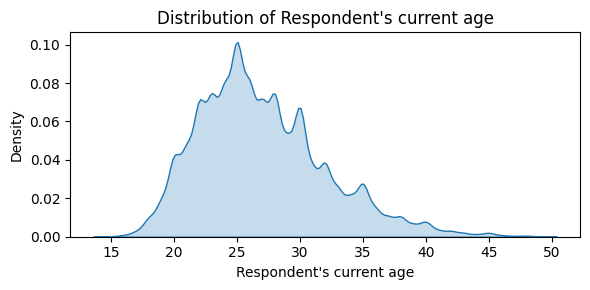

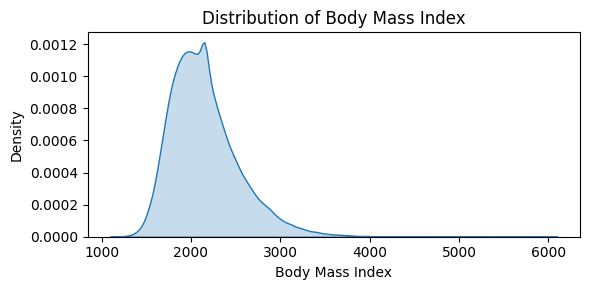

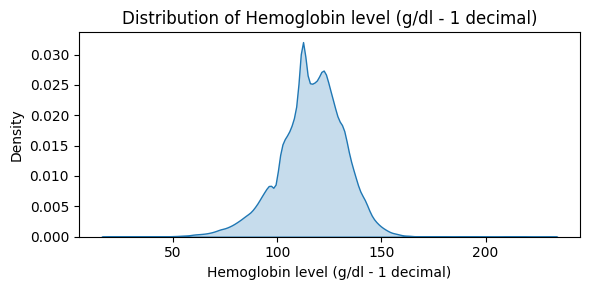

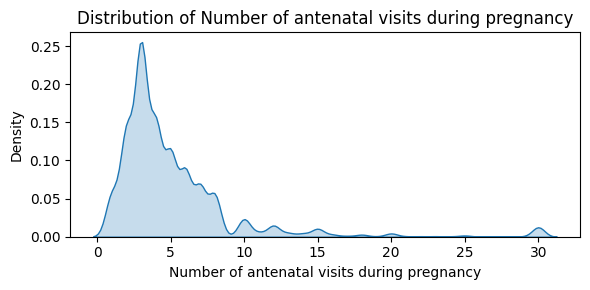

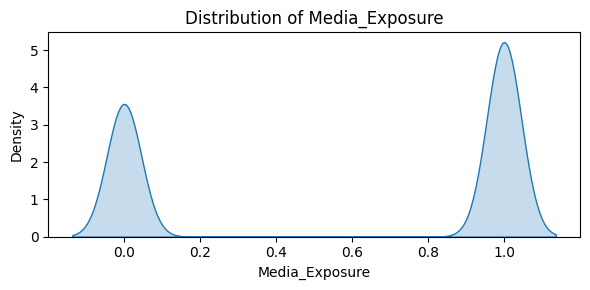

In [7]:
# =============================================
#               IMPORETD LIBRARIES
# =============================================
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# =============================================
#     1. Data Loading and Initial Cleaning
# =============================================
try:
    df_temp = pd.read_csv('new lbw cleaned_data .csv', header=None, low_memory=False)
    new_column_names = df_temp.iloc[0].tolist()
    df = df_temp.iloc[1:].copy()
    df.columns = new_column_names

    print("Dataset loaded successfully with corrected headers.")
    print("First 5 rows of the dataset:")
    print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

except FileNotFoundError:
    print("Error: 'new lbw cleaned_data .csv' not found. Please ensure the file is in the correct path.")
    exit()

TARGET = 'Birth weight in kilograms (3 decimals)'
DEMOGRAPHIC = ["Respondent's current age", 'Type of place of residence']
SOCIOECONOMIC = ['Highest educational level', 'Wealth index',
                'Frequency of reading newspaper or magazine',
                'Frequency of watching television']
HEALTH = ['Body Mass Index', 'Hemoglobin level (g/dl - 1 decimal)',
         'Anemia level', 'Currently has thyroid disorder']
BEHAVIORAL = ['Gutkha/Paan masala with tobacco', 'Drinks alcohol',
             'Frequency eats pulses or beans',
             'Frequency eats dark green leafy vegetable',
             'Frequency eats fruits']
PREGNANCY = ['Number of antenatal visits during pregnancy']

numerical_columns_to_convert = [
    "Respondent's current age",
    "Marriage to first birth interval (months)",
    "Number of antenatal visits during pregnancy",
    TARGET,
    "Body Mass Index",
    "Hemoglobin level (g/dl - 1 decimal)"
]

for col in numerical_columns_to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in the DataFrame. Skipping conversion.")

print("\nData types after initial numeric conversion:")
print(df.info())

# =============================================
#    2. Data Cleaning (Continued - Original)
# =============================================
df['LBW'] = np.where(df[TARGET] < 2500, 1, 0)

# =============================================
#           3. Feature Engineering
# =============================================
if 'Frequency of watching television' in df.columns and 'Frequency of reading newspaper or magazine' in df.columns:
    df['Media_Exposure'] = np.where(
        (df['Frequency of watching television'] == 'Almost every day') |
        (df['Frequency of reading newspaper or magazine'] == 'Almost every day'),
        1, 0
    )
else:
    print("Warning: Media features not found. Skipping 'Media_Exposure' creation.")
    df['Media_Exposure'] = 0

# =============================================
#     4. Preprocessing Pipeline (Original)
# =============================================
numeric_features = [col for col in ["Respondent's current age", 'Body Mass Index',
                                   'Hemoglobin level (g/dl - 1 decimal)',
                                   'Number of antenatal visits during pregnancy'] if col in df.columns]

categorical_features = [col for col in ['Type of place of residence', 'Highest educational level',
                                       'Wealth index', 'Anemia level'] if col in df.columns]

if 'Media_Exposure' in df.columns:
    numeric_features.append('Media_Exposure')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# =============================================
#        5. Train-Test Split (Original)
# =============================================
df = df.dropna(subset=[TARGET, 'LBW'])
all_features = list(set(numeric_features + categorical_features + ['Media_Exposure']))
all_features_existing = [col for col in all_features if col in df.columns]

X = df[all_features_existing].copy()
y = df['LBW'].copy()

print("\n--- Pre-split Target Variable Distribution ---")
print(y.value_counts())
print("-" * 40)

# =============================================
#   6. MODEL TRAINING AND TESTING STARTS HERE
# =============================================
# Additional imports
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import shap
from tabulate import tabulate

# Enhanced train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# =============================================
# 7. Model Development with Comparison Table
# =============================================
# Initialize models
models = {
    "Original RF": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=5,
            class_weight='balanced', random_state=42))
    ]),
    "Tuned RF": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            use_label_encoder=False, eval_metric='logloss',
            scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
            random_state=42))
    ])
}

# Hyperparameter tuning for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5]
}
grid_search = GridSearchCV(models["Tuned RF"], param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
models["Tuned RF"] = grid_search.best_estimator_
print(f"\nBest RandomForest parameters: {grid_search.best_params_}")

# Train and evaluate all models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision (1)": report["1"]["precision"],
        "Recall (1)": report["1"]["recall"],
        "F1 (1)": report["1"]["f1-score"],
        "Precision (0)": report["0"]["precision"],
        "Recall (0)": report["0"]["recall"],
        "F1 (0)": report["0"]["f1-score"]
    })

# Display comparison table
print("\n=== Model Comparison ===")
print(tabulate(pd.DataFrame(results).sort_values("Accuracy", ascending=False),
               headers="keys", tablefmt="psql", showindex=False))

# ===================================================
# 8. Detailed Visualization for Best Model (Tuned RF)
# ===================================================
best_model = models["Tuned RF"]
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Enhanced Confusion Matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            annot_kws={"size": 16}, cbar=False,
            xticklabels=['Normal Weight', 'Low Weight'],
            yticklabels=['Normal Weight', 'Low Weight'])
plt.title('Tuned Random Forest - Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()

# Feature Importance
fitted_preprocessor = best_model.named_steps['preprocessor']
fitted_onehot_encoder = fitted_preprocessor.named_transformers_['cat'].named_steps['onehot']
feature_names = np.concatenate([
    numeric_features,
    fitted_onehot_encoder.get_feature_names_out(categorical_features)
])

importances = best_model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 15 Feature Importances - Tuned Random Forest', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# =============================================
#      9. DALEX INTERPRETER VISUALIZATION
# =============================================
# Install if not already installed
# !pip install dalex

import dalex as dx

# Create explainer for the full pipeline
explainer = dx.Explainer(
    best_model,  # Full pipeline (preprocessor + classifier)
    X_test,      # Raw test data
    y_test,      # True labels
    label="Tuned Random Forest"
)

# 1. Feature Importance
model_parts = explainer.model_parts()
model_parts.plot(title="DALEX - Feature Importance")

# 2. Single prediction breakdown (use raw X_test row directly)
sample_idx = 0
observation = X_test.iloc[[sample_idx]]
prediction_breakdown = explainer.predict_parts(observation, type='break_down')
prediction_breakdown.plot(title=f"DALEX - Prediction Breakdown (Index: {sample_idx})")

# 3. Partial Dependence Profile (Fixed: Use only original variables from X_test)
valid_features = list(X_test.columns)
top_variables = model_parts.result.sort_values('dropout_loss', ascending=False)['variable']

# Filter to only valid (original) features
top3_features = [var for var in top_variables if var in valid_features][:3]

# Now generate PDP safely
if top3_features:
    pdp = explainer.model_profile(variables=top3_features)
    pdp.plot(title="DALEX - Partial Dependence Profiles")
else:
    print("No valid original features found in top variables for PDP.")

# =============================================
#        10. Original Actionable Insights
# =============================================
print("\n--- Actionable Insights Based on Tuned Random Forest ---")
top_features = importance_df.head(5)['Feature'].str.lower().tolist()

insights = {
    'hemoglobin|anemia': "Anemia screening and iron supplementation programs during pregnancy",
    'bmi|body mass': "Healthy weight management programs for expecting mothers",
    'age': "Education on optimal reproductive age for conception",
    'antenatal|prenatal': "Improved access to prenatal care visits",
    'education': "Maternal education programs focusing on health knowledge",
    'wealth|economic': "Economic support programs for expecting families",
    'residence': "Targeted interventions for rural/urban disparities",
    'media': "Health education through media channels"
}

print("\nTop recommended interventions based on model insights:")
for pattern, recommendation in insights.items():
    if any(any(p in feature for p in pattern.split('|')) for feature in top_features):
        print(f"- {recommendation}")

# =============================================
#    11. Feature Distribution Visualization
# =============================================
for col in numeric_features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=X, x=col, fill=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()
